In [18]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt

In [3]:
theta = Parameter("$\\theta$")

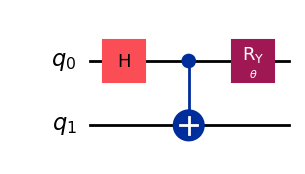

In [5]:
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw('mpl')

In [1]:
number_of_phases = 50
phases = [2 * np.pi * i / number_of_phases for i in range(number_of_phases)]
individual_phases = [[ph] for ph in phases]
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])


NameError: name 'np' is not defined

In [40]:
from qiskit.primitives import StatevectorEstimator

In [41]:
estimator = StatevectorEstimator()

In [42]:
pub = (chsh_circuit, observable, individual_phases)

In [43]:
job = estimator.run([pub])

In [44]:
result = job.result()[0].data.evs

In [45]:
print(result)

[ 2.          1.32163526  0.52583743 -0.31668336 -1.13106545 -1.84494741
 -2.39489769 -2.73205081 -2.82644922 -2.66970521 -2.27574618 -1.67957712
 -0.93417026 -0.10575827  0.73205081  1.50481396  2.14386778  2.59242955
  2.81064257  2.77911766  2.50065596]


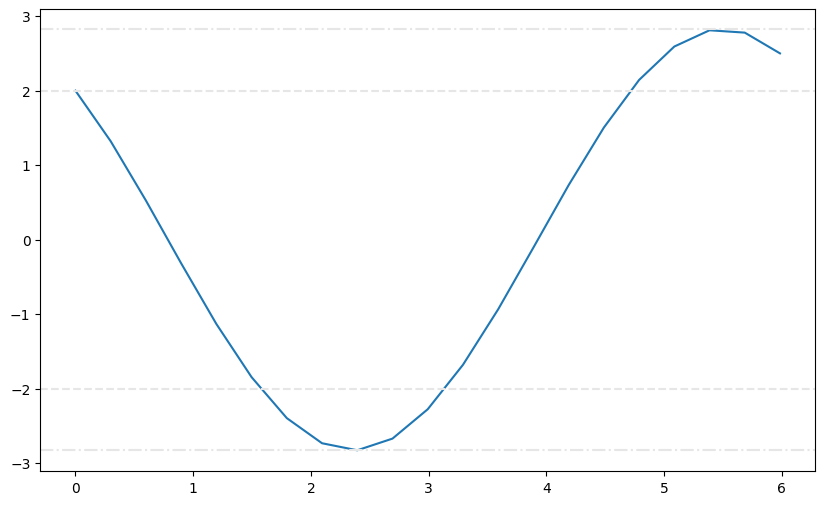

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(individual_phases, result)
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")

In [48]:
for i in range(len(result)):
    if result[i] > 2 or result[i] < -2:
        print(f'Angle: {individual_phases[i]}\n Value: {result[i]}')
        print("---------")

Angle: [1.7951958020513104]
 Value: -2.3948976922762757
---------
Angle: [2.0943951023931953]
 Value: -2.7320508075688767
---------
Angle: [2.3935944027350806]
 Value: -2.826449219201491
---------
Angle: [2.6927937030769655]
 Value: -2.669705214039954
---------
Angle: [2.9919930034188504]
 Value: -2.275746184802606
---------
Angle: [4.787188805470161]
 Value: 2.1438677815352083
---------
Angle: [5.086388105812047]
 Value: 2.5924295460211986
---------
Angle: [5.385587406153931]
 Value: 2.8106425686535257
---------
Angle: [5.6847867064958155]
 Value: 2.7791176647592333
---------
Angle: [5.983986006837701]
 Value: 2.5006559603940905
---------
